In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d, fftconvolve
from scipy.fft import fft2, ifft2
from PIL import Image, ImageEnhance
import urllib.request
from scipy.ndimage import median_filter
from skimage import morphology
import os
import glob
from tqdm import tqdm
import cv2
import imageio
import tifffile as tiff

In [125]:

def wiener_filter(blurred_noisy_img, psf, snr):
    """
    Apply Wiener filter to deblur an image.
    
    Parameters:
        blurred_noisy_img (np.array): 2D array of the blurred and noisy image.
        psf (np.array): 2D array of the point spread function.
        snr (float): Signal to noise ratio.
        
    Returns:
        np.array: 2D array of the deblurred image.
    """
    # Get the Fourier Transform of the image and PSF
    g = fft2(blurred_noisy_img)
    h = fft2(psf, s=blurred_noisy_img.shape)
    
    # Apply Wiener filter
    wiener_filter = np.conj(h) / (np.abs(h)**2 + 1/snr)
    restored_img = np.abs(ifft2(g * wiener_filter))
    
    return restored_img

In [126]:
def normalize_image(img_array):
    # Find min and max values in the array
    min_val = np.min(img_array)
    max_val = np.max(img_array)

    # Normalize to [0, 255]
    normalized = ((img_array - min_val) / (max_val - min_val) * 255).astype(np.float32)
    
    return normalized


In [127]:
def substract_stat(frames):
    print(frames[0].shape)
    pixel_sum=np.zeros(shape=(frames[0].shape[0], frames[0].shape[1]))
    
    for frame in tqdm(frames, desc='Substracting the background noise'):
        frame = np.array(frame)
        frame=frame/255.0
        pixel_sum+=frame

    im_average = ((pixel_sum/len(frames))*255)
    
    substracted_frames = [normalize_image((np.asarray(frame)-im_average).astype(np.float32)) for frame in frames]
    
        
    return substracted_frames

In [128]:
def read_tif(tif_file_url):
    frames=imageio.mimread(tif_file_url, memtest=False)
    
    return frames

In [129]:
def write_tif(frames, path):
    output_folder = path
    tiff_writer=tiff.TiffWriter(output_folder, bigtiff=True)
    
    for frame in frames:
        tiff_writer.save(frame, compression=0, metadata={}, contiguous=False)

In [130]:
def filter_frames(frames, psf, snr):
    print(len(frames))
    filtered_frames=[]

    for frame in tqdm(frames, desc="Filtering"):

        frame = wiener_filter(frame, psf, snr=snr)
        frame=median_filter(frame, size=3)

        frame=Image.fromarray(frame)
        frame = frame.convert("L")
        
        enhancer = ImageEnhance.Brightness(frame)
        frame=enhancer.enhance(1)

        frame=np.asarray(frame).astype(np.float32)

        filtered_frames.append(frame)

    print("out_this_loop")

    return filtered_frames

(540, 720)


Substracting the background noise: 100%|██████████| 1000/1000 [00:01<00:00, 921.41it/s]


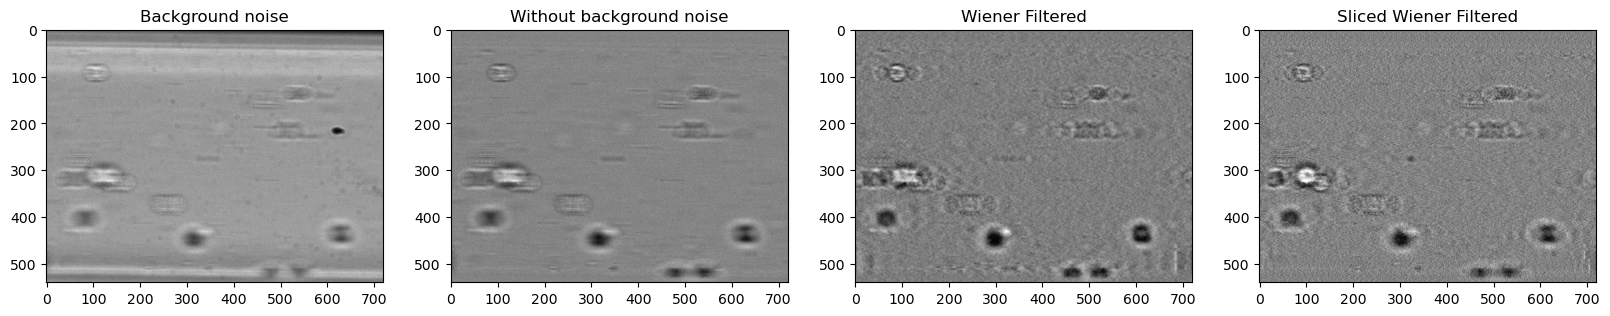

In [131]:

# Load your image
# blurred_noisy_img = plt.imread('path_to_your_image.png')

# Define your PSF (you should have it or estimate it)
# For example, a simple motion blur might be represented as:
psf = np.zeros((35, 35))
psf[0, 0:35] = 1
psf /= psf.sum()

tif_url="C:/Users/mriza/Desktop/Final_test_copies_fiji/2023_08_08_20_34_22.tif"
tif_frames=read_tif(tif_url)

substracted_frames=substract_stat(tif_frames)
#filtered_frames= filter_frames(substracted_frames, psf, 150)
#write_tif(filtered_frames, "C:/Users/mriza/Desktop/Final_test_copies_fiji/filtered_tiff/2023_08_08_20_34_22_filtered.tif")

original_noised=tif_frames[300]
original=substracted_frames[300]
original_copy=original.copy()

blurred_noisy_img = fftconvolve(original, psf, mode='same')
blurred_noisy_img += 1e-7 * blurred_noisy_img.std() * np.random.standard_normal(blurred_noisy_img.shape)

#Sliced Wiener Filter
range1=np.arange(0,50)
range2=np.arange(50,190)
range3=np.arange(190,250)
range4=np.arange(250,350)
range5=np.arange(350, 410)
range6=np.arange(410,490)
range7=np.arange(490,540)

ranges=[range1, range2, range3, range4, range5, range6, range7]

psf1 = np.zeros((15, 15))
psf1[0, :] = 1
psf1 /= psf1.sum()

psf2 = np.zeros((25, 25))
psf2[0, :] = 1
psf2 /= psf2.sum()

psf3 = np.zeros((35, 35))
psf3[0, :] = 1
psf3 /= psf3.sum()

psf4 = np.zeros((45, 45))
psf4[0, :] = 1
psf4 /= psf4.sum()

psf5 = np.zeros((35, 35))
psf5[0, :] = 1
psf5 /= psf5.sum()

psf6 = np.zeros((25, 25))
psf6[0, :] = 1
psf6 /= psf6.sum()

psf7 = np.zeros((15, 15))
psf7[0, :] = 1
psf7 /= psf7.sum()

psfs=[psf1, psf2, psf3, psf4, psf5, psf6, psf7]

#plt.imshow(original[range1])

image_parts=[original[srange] for srange in ranges]

for i in np.arange(0, len(ranges)):
    
    original[ranges[i]]=wiener_filter(original[ranges[i]], psf=psfs[i],snr=75)
    
original=Image.fromarray(original)
original = original.convert("L")

enhancer = ImageEnhance.Brightness(original)
original=enhancer.enhance(1)

original=np.asarray(original).astype(np.float32)
wmedian = wiener_filter(original_copy, psf, snr=75)
wmedian=median_filter(wmedian, size=3)

# Plot images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(original_noised, cmap='gray')
ax[0].set_title('Background noise')

ax[1].imshow(original_copy, cmap='gray')
ax[1].set_title('Without background noise')

ax[2].imshow(wmedian, cmap='gray')
ax[2].set_title('Wiener Filtered')

ax[3].imshow(original, cmap='gray')
ax[3].set_title('Sliced Wiener Filtered')

plt.show()
